In [8]:
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, cpu_count
import ghostipy as gsp
from scipy.signal import find_peaks, resample, spectrogram
from pathlib import Path
import seaborn as sns
from scipy.stats import gaussian_kde
import scipy.ndimage as ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.colors as mcolors
from PIL import ImageColor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from readers import OpenEphysReader
from utils import run_parallel

In [2]:
data_dir = '/media/sil2/Data/Nimrod/experiments/PV_24'
# rec_dirs = list(Path(data_dir).rglob('Record Node 101'))

In [3]:
%%time
rec_dirs = [
    f'{data_dir}/29_12_2021/block_23/oe_files/PV24_29_12_21_EE23_2021-12-29_11-10-57/Record Node 101',
    f'{data_dir}/13_03_2022/block_96/oe_files/PV24_PC4_2022-03-13_15-24-57/Record Node 101',
    f'{data_dir}/16_01_2022/block_82/oe_files/PV24_16_1_22_EE82_2022-01-16_14-05-02/Record Node 101',
    f'{data_dir}/09_03_2022/block_95/oe_files/PV24_09_03_2022_PC2_2022-03-09_14-45-05/Record Node 101'
]

def cwt(v_, t_, fs=None):
    coefs, _, freqs, ts, _ = gsp.cwt(v_, fs=fs, timestamps=t_,
                                                   freq_limits=[0.5, 290], voices_per_octave=10)
    psd = np.abs(coefs)**2 / fs
    return psd, freqs, ts - ts[0]


decimate_q = 20
window_time = 1.5  # seconds
X, V = [], []
for p in tqdm(rec_dirs):
    rd = OpenEphysReader(p, channel=17)
    v, t = rd.read()
    v, t = resample(v, len(v)//decimate_q, t)
    fs = rd.fs / decimate_q
    window = int(fs*window_time)
    iterable = [(v[i:i+window], t[i:i+window]) for i in np.arange(0, len(v), window) if (i + window) <= len(v)]
    x_ = run_parallel(cwt, iterable, fs=fs)
    frequencies, timestamps = x_[0][1], x_[0][2]
    X.extend([z[0] for z in x_])
    V.extend([z[0] for z in iterable])

del x_, iterable, v, t
X = np.vstack([x.reshape(1, *x.shape) for x in X])
V = np.vstack(V)
X.shape

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 1min 40s, sys: 21.1 s, total: 2min 1s
Wall time: 11min 35s


(3504, 92, 1500)

In [4]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, unflattened_size):
        super().__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(int(np.prod(unflattened_size)), 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, unflattened_size):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, int(np.prod(unflattened_size))),
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=unflattened_size)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


def get_ae_transform(resize_dims):
    return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(resize_dims),
            transforms.ToTensor(),
            # transforms.Normalize(
            #     mean=[0.485, 0.456, 0.406],
            #     std=[0.229, 0.224, 0.225],
            # ),
        ])


def find_ae_parameters(x, resize_dims, hidden_dim):
    transform = get_ae_transform(resize_dims)
    x0 = transform(x[0].astype(np.float32)).unsqueeze(0)
    enc = Encoder(encoded_space_dim=hidden_dim, unflattened_size=(1,1,1))
    unflattened_size = enc.encoder_cnn(x0).detach().numpy().shape[1:]

    enc = Encoder(encoded_space_dim=hidden_dim, unflattened_size=unflattened_size)
    dec = Decoder(encoded_space_dim=hidden_dim, unflattened_size=unflattened_size)
    new_resize_dims = dec(enc(x0)).detach().numpy().shape[2:]

    if new_resize_dims != resize_dims:
        print(f'Need to change resize_dims from {resize_dims} to {new_resize_dims}')
    return new_resize_dims, unflattened_size


class AutoEncoder:
    def __init__(self, hidden_dim=4, lr=0.001, resize_dims=(76, 596), unflattened_size=(32, 9, 74)):
        self.loss_fn = torch.nn.MSELoss()
        self.lr = lr
        self.hidden_dim = hidden_dim
        self.resize_dims = resize_dims
        self.transform = get_ae_transform(resize_dims)
        torch.manual_seed(0)  ### Set the random seed for reproducible results
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        #model = Autoencoder(encoded_space_dim=encoded_space_dim)
        self.encoder = Encoder(encoded_space_dim=hidden_dim, unflattened_size=unflattened_size)
        self.decoder = Decoder(encoded_space_dim=hidden_dim, unflattened_size=unflattened_size)
        params_to_optimize = [
            {'params': self.encoder.parameters()},
            {'params': self.decoder.parameters()}
        ]
        self.optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
        self.encoder.to(self.device)
        self.decoder.to(self.device)

    def preprocess_data(self, x, batch_size, test_size):
        n_obs = x.shape[0]
        dataset = CWTDataset(x, x, transform=self.transform)
        n_test = int(n_obs*test_size)
        train_dataset, test_dataset = random_split(dataset, [n_obs-n_test, n_test])
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        return train_loader, test_loader, test_dataset

    def train(self, x, num_epochs=30, batch_size=256, test_size=0.2, verbose=True):
        train_loader, test_loader, test_data = self.preprocess_data(x, batch_size, test_size)
        diz_loss = {'train_loss': [], 'val_loss': []}
        for epoch in range(num_epochs):
           train_loss = self.train_epoch(train_loader, verbose)
           val_loss = self.test_epoch(test_loader)
           if verbose:
                print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
           diz_loss['train_loss'].append(train_loss)
           diz_loss['val_loss'].append(val_loss)
           if verbose:
                self.plot_ae_outputs(test_data, n=10)
        print(f'Finish training. train_loss={train_loss:.3f}, val_loss={val_loss:.3f}')

    def train_epoch(self, loader, verbose=True):
        # Set train mode for both the encoder and the decoder
        self.encoder.train()
        self.decoder.train()
        train_loss = []
        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for image_batch, _ in loader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
            # Move tensor to the proper device
            image_batch = image_batch.to(self.device)
            encoded_data = self.encoder(image_batch)
            decoded_data = self.decoder(encoded_data)
            # Evaluate loss
            loss = self.loss_fn(decoded_data, image_batch)
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if verbose:
                print('\t partial train loss (single batch): %f' % (loss.data))
            train_loss.append(loss.detach().cpu().numpy())
        return np.mean(train_loss)

    def test_epoch(self, loader):
        # Set evaluation mode for encoder and decoder
        self.encoder.eval()
        self.decoder.eval()
        with torch.no_grad(): # No need to track the gradients
            conc_out = []
            conc_label = []
            for image_batch, _ in loader:
                image_batch = image_batch.to(self.device)  # Move tensor to the proper device
                encoded_data = self.encoder(image_batch)  # Encode data
                decoded_data = self.decoder(encoded_data)  # Decode data
                # Append the network output and the original image to the lists
                conc_out.append(decoded_data.cpu())
                conc_label.append(image_batch.cpu())
            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label)
            # Evaluate global loss
            val_loss = self.loss_fn(conc_out, conc_label)
        return val_loss.data

    def plot_ae_outputs(self, test_dataset, n=10):
        plt.figure(figsize=(16,4.5))
        targets = test_dataset.dataset.target.numpy()
        t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
        for i in range(n):
          ax = plt.subplot(2,n,i+1)
          img = test_dataset[t_idx[i]][0].unsqueeze(0).to(self.device)
          self.encoder.eval()
          self.decoder.eval()
          with torch.no_grad():
             rec_img  = self.decoder(self.encoder(img))
          plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
          if i == n//2:
            ax.set_title('Original images')
          ax = plt.subplot(2, n, i + 1 + n)
          plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
          if i == n//2:
             ax.set_title('Reconstructed images')
        plt.show()


class CWTDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [5]:
%%time
hidden_dim = 2
batch_size = 128
resize_dims, unflattened_size = find_ae_parameters(X, (92, 596), hidden_dim=hidden_dim)
ae = AutoEncoder(lr=0.001, hidden_dim=hidden_dim, resize_dims=resize_dims, unflattened_size=unflattened_size)
ae.train(X, num_epochs=30, batch_size=batch_size, test_size=0.2, verbose=False)

Finish training. train_loss=0.036, val_loss=0.036
CPU times: user 1h 2min 27s, sys: 3min 17s, total: 1h 5min 44s
Wall time: 3min 19s


In [6]:
%matplotlib inline
train_loader, _, _ = ae.preprocess_data(X, batch_size, 0.001)
ae.encoder.eval()
with torch.no_grad(): # No need to track the gradients
    conc_out = []
    conc_label = []
    for image_batch, _ in train_loader:
        image_batch = image_batch.to(ae.device)  # Move tensor to the proper device
        encoded_data = ae.encoder(image_batch)  # Encode data
        conc_out.append(encoded_data.cpu())
    conc_out = torch.cat(conc_out)
conc_out = conc_out.numpy()
# plt.scatter(conc_out[:,0], conc_out[:,1])

silhouette_score = 0.29


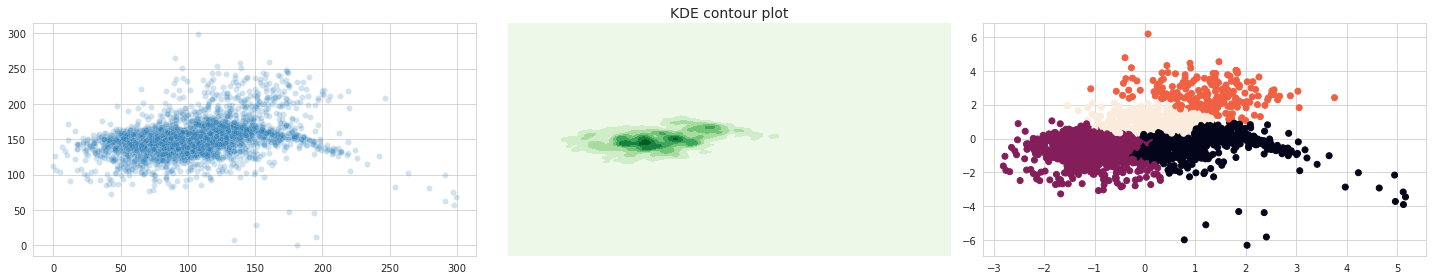

In [9]:
HCOLORS = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
COLORS = [tuple([i/256 for i in ImageColor.getcolor(x, 'RGB')] + [1]) for x in HCOLORS]

def apply_kde(data, bw_method=0.08, ax=None):
    x = data[:, 0]
    y = data[:, 1]
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values, bw_method=bw_method)
    kd = np.reshape(kernel(positions).T, xx.shape)

    # convert points to image bins, used for grouping after watershed
    binned_data = np.ndarray(shape=data.shape)
    binned_data[:,0] = (data[:,0] - xmin) / (xmax - xmin) * (xx.shape[0] - 1)
    binned_data[:,1] = (data[:,1] - ymin) / (ymax - ymin) * (yy.shape[0] - 1)

    if ax is None:
        ax = plt.subplot()
    ax.contourf(xx, yy, kd, cmap='Greens') #, vmin=0.01)
    ax.set_title('KDE contour plot', fontsize=14)
    ax.axis('off')

    return kd, binned_data, axes

def apply_watershed(image, is_gray=False, min_distance=10):
    # Load in image, convert to gray scale, and Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if not is_gray else image.copy()
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Compute Euclidean distance from every binary pixel
    # to the nearest zero pixel then find peaks
    distance_map = ndimage.distance_transform_edt(thresh)
    local_max = peak_local_max(distance_map, indices=False, min_distance=min_distance, labels=thresh, footprint=np.ones((10, 10)))

    # Perform connected component analysis then apply Watershed
    markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
    labels = watershed(-distance_map, markers, mask=thresh)

    n_labels = len(np.unique(labels))
    print(f'Number of labels found by watershed: {n_labels}')
    selected_contours = []
    for i, label in enumerate(np.unique(labels)):
        if label == 0:
            continue

        # Create a mask
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255

        # Find contours and determine contour area
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        selected_contours.append(max(cnts, key=cv2.contourArea))

    return selected_contours

def get_states(binned_data, kd, max_points=100, ax=None):
    f2 = (kd - kd.min()) / (kd.max() - kd.min()) * 255
    f2 = np.rot90(f2).astype('uint8').copy()
    # f2 = f2.astype('uint8').copy()
    # f2 = ndimage.rotate(f2, 180)
    cnts = apply_watershed(f2.copy(), is_gray=True)
    cmap = plt.cm.gray
    norm = plt.Normalize(f2.min(), f2.max())
    f2 = cmap(norm(f2))
    groups = {}
    for cnt_id, cnt in enumerate(cnts):
        cv2.fillPoly(f2, pts =[cnt], color=COLORS[cnt_id])
        cv2.drawContours(f2, [cnt], -1, (0,0,0,1), 1)
        cv2.putText(f2, str(cnt_id+1), (int(cnt[:,0,0].mean()), int(cnt[:,0,1].mean())), cv2.FONT_HERSHEY_PLAIN, 1, (1,1,1))
        c = 0
        for i, pnt in enumerate(binned_data):
            if c >= max_points:
                break
            glist = groups.setdefault(cnt_id+1, [])
            if cv2.pointPolygonTest(cnt, tuple(pnt), True) > 0:
                glist.append(i)
                c += 1

    if ax is None:
        ax = plt.subplot()
    ax.imshow(f2, interpolation='nearest')
    ax.axis('off')
    return groups


fig, axes = plt.subplots(1, 3, figsize=(20, 4))
kd, binned_data, _ = apply_kde(conc_out, ax=axes[1])

X_norm = StandardScaler().fit_transform(binned_data)
# clustering = DBSCAN(eps=0.2, min_samples=10, metric='euclidean').fit(X_norm)
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=30, linkage='ward').fit(X_norm)
sil = silhouette_score(X_norm, clustering.labels_)
print(f'silhouette_score = {sil:.2f}')
n_labels = len(np.unique(clustering.labels_))

sns.scatterplot(x=binned_data[:,0], y=binned_data[:,1], alpha=0.2, ax=axes[0])
axes[2].scatter(X_norm[:,0], X_norm[:,1], c=clustering.labels_)

fig.tight_layout()

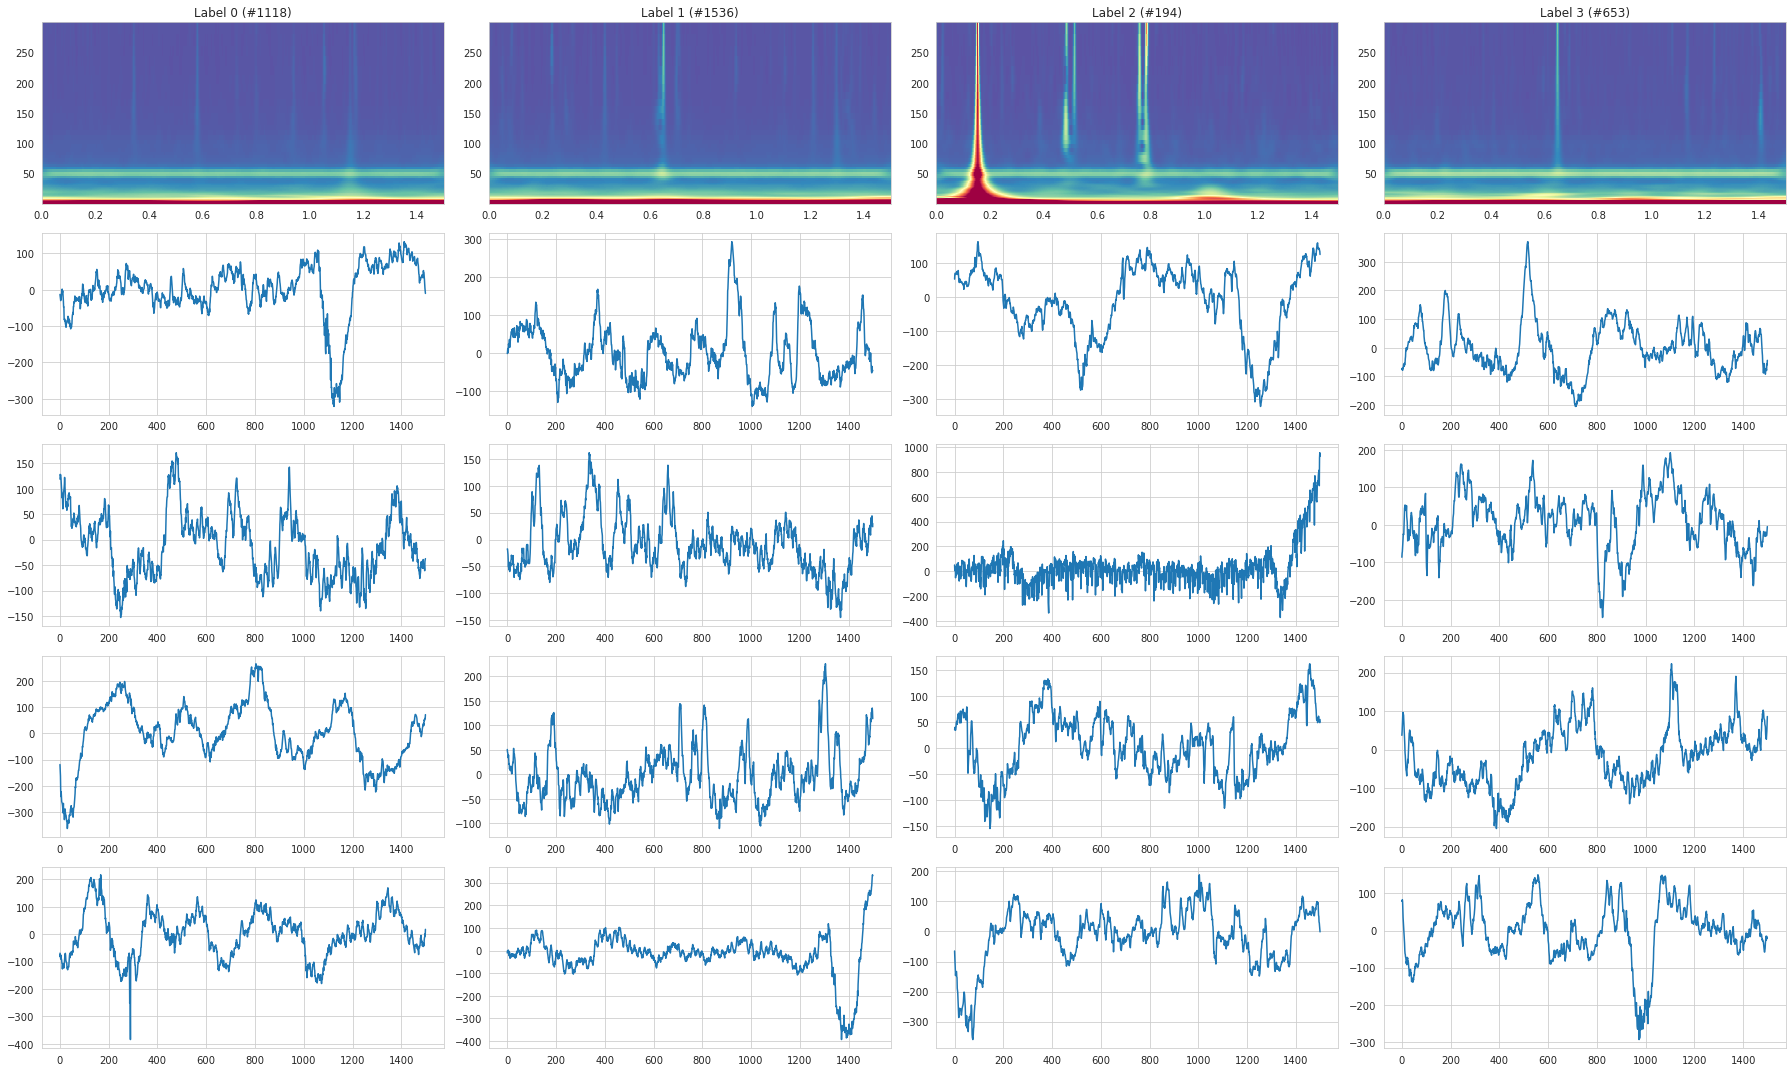

In [30]:
def plot_clusters_profiles(n_examples=4):
    labels = np.unique(clustering.labels_)
    fig, axes = plt.subplots(n_examples+1, len(labels), figsize=(25, 3*(n_examples+1)))
    for i, lbl in enumerate(labels):
        idx = np.where(clustering.labels_ == lbl)[0]
        x_ = X[idx]
        meanx = x_.mean(axis=0)
        axes[0, i].grid(False)
        axes[0, i].pcolormesh(timestamps, frequencies, meanx, cmap=plt.cm.Spectral_r, vmin=0, vmax=1, linewidth=0, rasterized=True, shading='auto')
        axes[0, i].set_title(f'Label {lbl} (#{len(idx)})')
        x_center, y_center = X_norm[idx].mean(axis=0)
        examples_idx = np.argsort(np.sqrt((X_norm[:,0]-x_center)**2 + (X_norm[:,1]-y_center)**2))[:n_examples]
        for j, exi in enumerate(examples_idx):
            axes[j+1, i].plot(V[exi])

    fig.tight_layout()

plot_clusters_profiles()

In [27]:
x,y = X_norm[np.where(clustering.labels_==0)[0]].mean(axis=0)
print(x, y)
srt = np.argsort(np.sqrt((X_norm[:,0]-x)**2 + (X_norm[:,1]-y)**2))
for i in srt[:5]:
    print(X_norm[i])

0.766237462284937 -0.2679296873613378
[ 0.74237111 -0.25161821]
[ 0.71573906 -0.29835309]
[ 0.83378858 -0.26444385]
[ 0.7141169  -0.22036915]
[ 0.84107608 -0.26586015]


  0%|          | 0/7 [00:00<?, ?it/s]

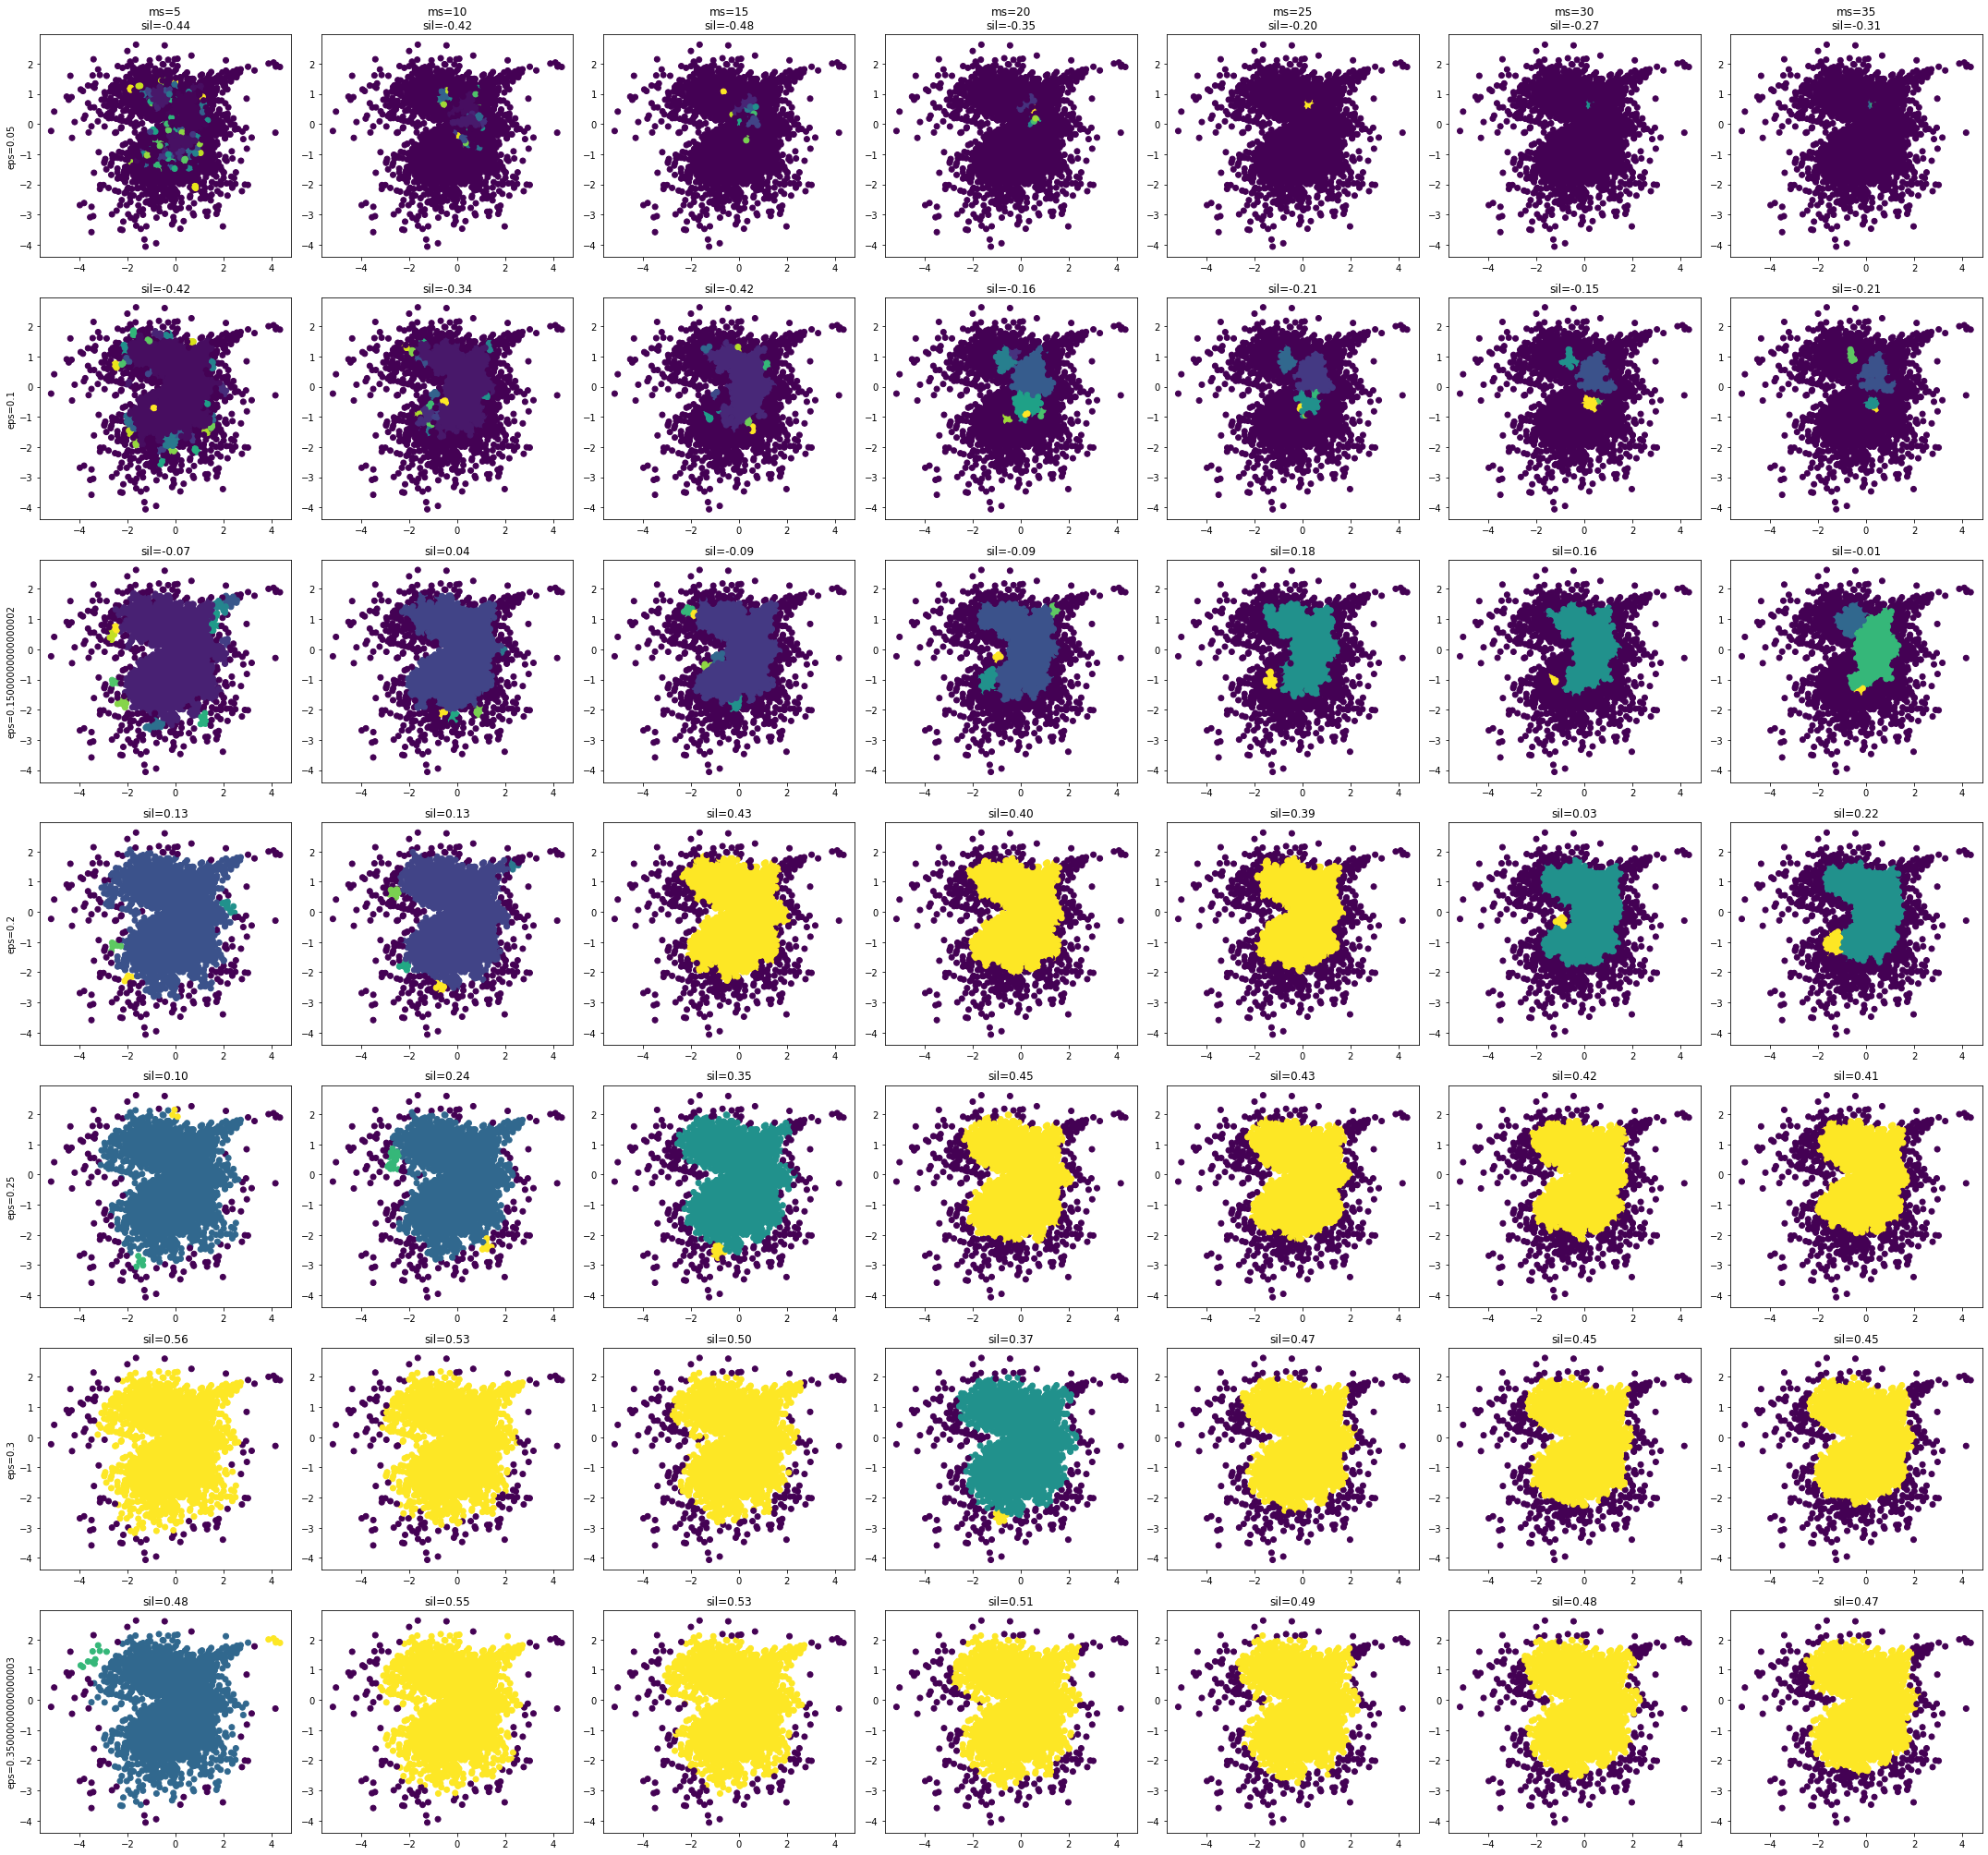

In [318]:




sils = []
fig, axes = plt.subplots(7,7,figsize=(30, 7*4))

for i, eps in enumerate(tqdm(np.arange(0.05, 0.4, 0.05))):
    for j, ms in enumerate(np.arange(5, 40, 5)):
        try:
            clustering = DBSCAN(eps=eps, min_samples=ms, metric='euclidean').fit(X_norm)
            sil = silhouette_score(X_norm, clustering.labels_)
            sils.append((eps, ms, sil))
            axes[i, j].scatter(X_norm[:,0], X_norm[:,1], c=clustering.labels_)
            if i == 0:
                axes[i, j].set_title(f'ms={ms}\nsil={sil:.2f}')
            else:
                axes[i, j].set_title(f'sil={sil:.2f}')
            if j == 0:
                axes[i, j].set_ylabel(f'eps={eps}')
        except:
            continue
sils.sort(key=lambda x: x[-1])
fig.tight_layout()

silhouette_score = 0.36


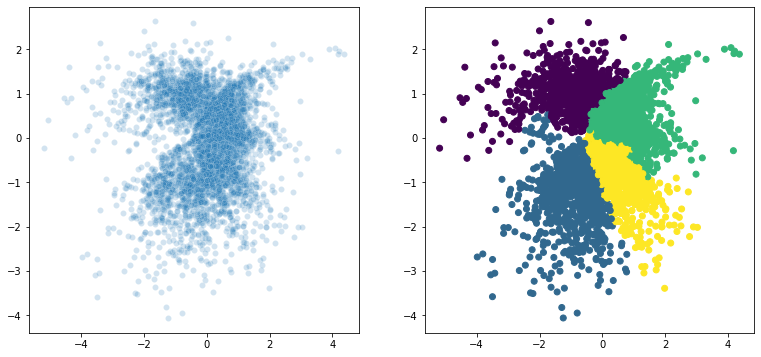

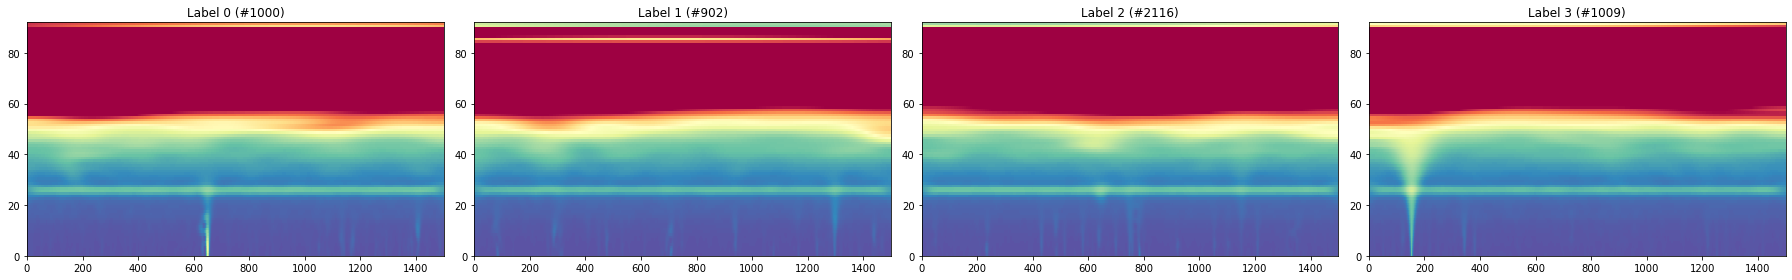

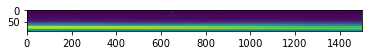

In [334]:
x_ = X[np.where(clustering.labels_ == 0)[0]].mean(axis=0)
plt.imshow(x_)
del x_

In [331]:
X.shape

(5032, 92, 1500)

In [266]:
l = [(0,3), (0,4), (0,1)]
l.sort(key=lambda x: x[1])
l

[(0, 1), (0, 3), (0, 4)]

In [210]:
from hmmlearn import hmm

gm = hmm.GaussianHMM(n_components=3)
gm.fit(v.reshape(-1, 1))
states = gm.predict(v.reshape(-1, 1))

In [215]:
np.split(states, np.unique(states, return_index=True))

TypeError: only integer scalar arrays can be converted to a scalar index

In [227]:
d = {'a': 1, 'b': 2, 'c': 3}
all(x > 0 for x in d.values())

True

In [226]:
v

array([31.34554754, 58.34517028, 50.18471753, ..., -2.36430139,
        3.34963127, -5.87484704])

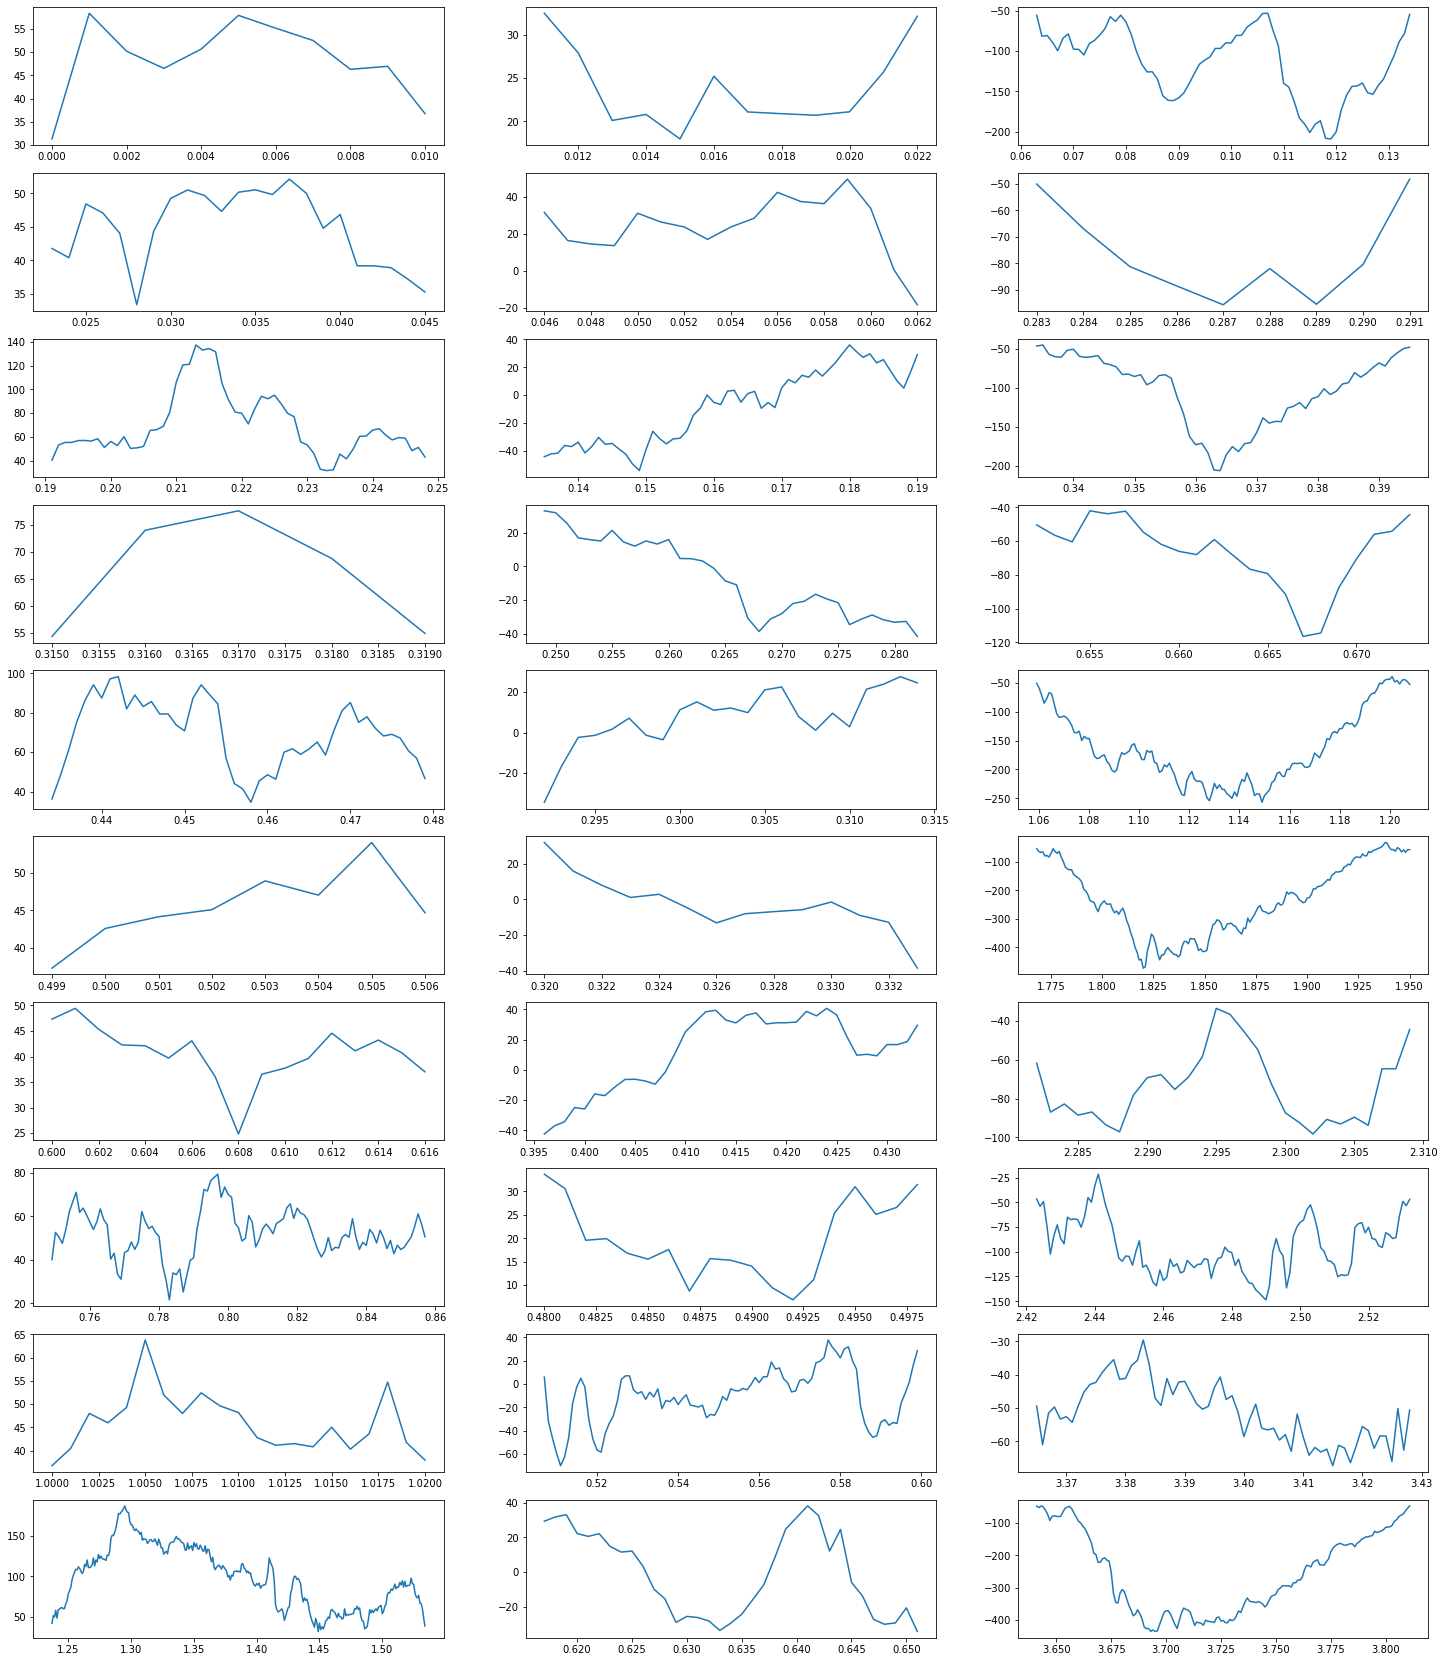

In [228]:
states_splitted = np.split(states, np.where(np.diff(states) != 0)[0] + 1)
states_splitted_idx = np.split(np.arange(len(states)), np.where(np.diff(states) != 0)[0] + 1)
max_plots = 10
c = {}
n_groups = 3
fig, axes = plt.subplots(max_plots, n_groups, figsize=(25, 3*max_plots))
for g, g_idx in zip(states_splitted, states_splitted_idx):
    if len(c) == n_groups and all(x >= max_plots for x in c.values()):
        break
    s_count = c.setdefault(g[0], 0)
    if s_count >= max_plots:
        continue
    axes[s_count, g[0]].plot(t[g_idx[0]:g_idx[-1]+1], v[g_idx[0]:g_idx[-1]+1])
    c[g[0]] += 1

In [110]:
foo = lambda x: ((x-9)/8) + 1

w = 98
for i in range(20):
    print(f'{w-i} - {foo(w - i)}')

98 - 12.125
97 - 12.0
96 - 11.875
95 - 11.75
94 - 11.625
93 - 11.5
92 - 11.375
91 - 11.25
90 - 11.125
89 - 11.0
88 - 10.875
87 - 10.75
86 - 10.625
85 - 10.5
84 - 10.375
83 - 10.25
82 - 10.125
81 - 10.0
80 - 9.875
79 - 9.75


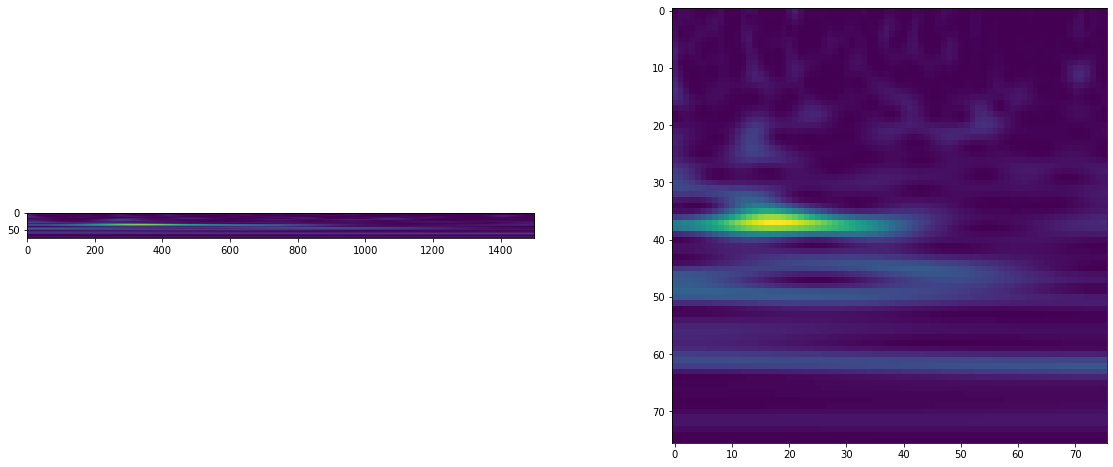

In [103]:
img = psds[0].copy()
fig, axes = plt.subplots(1,2,figsize=(20, 8))
axes[0].imshow(img)
resized = cv2.resize(img, (img.shape[0], img.shape[0]), interpolation = cv2.INTER_AREA)
axes[1].imshow(resized)

# frequencies: 76. PSD shape: (76, 20000)


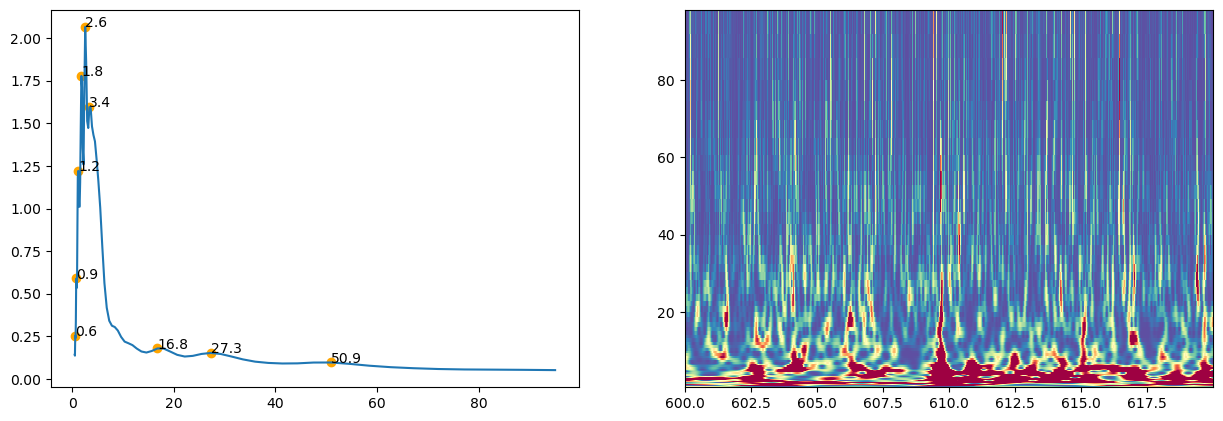

CPU times: user 7.1 s, sys: 1.01 s, total: 8.11 s
Wall time: 4.2 s


In [52]:
%%time
coefs, _, frequencies, timestamps, _ = gsp.cwt(v, fs=fs, timestamps=t, freq_limits=[0.5, 95], voices_per_octave=10)
psd = np.abs(coefs)**2 / fs
# frequencies, timestamps, psd = spectrogram(v, fs=fs, nperseg=int(fs*1))
# psd /= np.max(psd)

print(f'# frequencies: {len(frequencies)}. PSD shape: {psd.shape}')
freq_std = psd.mean(axis=1)
peaks, _ = find_peaks(freq_std)
fig, axes = plt.subplots(1,2,dpi=100, figsize=(15,5))
axes[0].plot(frequencies, freq_std)
axes[0].scatter(frequencies[peaks], freq_std[peaks], c='orange')
for pk in peaks:
  axes[0].text(frequencies[pk], freq_std[pk], f'{frequencies[pk]:.1f}')
axes[1].pcolormesh(timestamps, frequencies, psd, cmap=plt.cm.Spectral_r, vmin=0, vmax=1, linewidth=0, rasterized=True, shading='auto')
plt.show()

In [135]:
np.prod([1,2,3])

6

((92, 596), (32, 11, 74))

In [158]:
X.shape

(1243, 92, 1500)

CPU times: user 22min 51s, sys: 1min 16s, total: 24min 7s
Wall time: 1min 12s


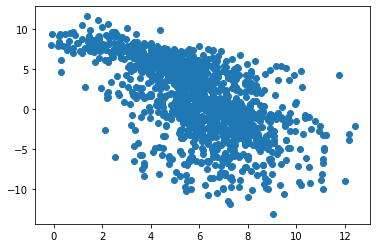

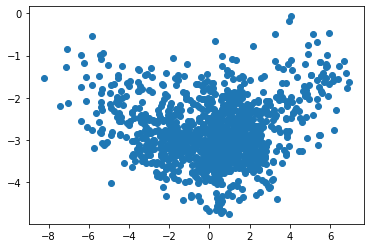

In [47]:
def foo():
    data = torch.from_numpy(psds).float()
    print(data[0].size())

foo()

torch.Size([76, 1500])


In [ ]:
torch.utils.data.DataLoader()

In [24]:
transforms.Compose([
    transforms.ToTensor(),
])(train_dataset)

TypeError: pic should be PIL Image or ndarray. Got <class 'torchvision.datasets.mnist.MNIST'>

In [22]:
train_dataset = datasets.MNIST('datasets', train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [61]:
transform = transforms.ToTensor()
psd_tensor = transform(psd.astype(np.float32))
output = model(psd_tensor.unsqueeze(0))
output.squeeze().detach().numpy()

(76, 20000)

In [56]:
def foo():
    datasets.MNIST(data_dir, train=True, download=True)


(76, 20000)

In [34]:
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
dataiter = iter(train_loader)
images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [36]:
images.size()

torch.Size([32, 3, 32, 32])

(0.0, 150.0)

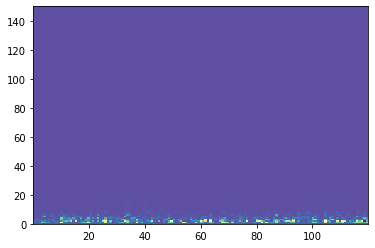

In [12]:
f_spect, t_spect, psd_spect = spectrogram(v, fs=fs, nperseg=int(fs*1))
psd_spect /= np.max(psd_spect)
plt.pcolormesh(t_spect, f_spect, psd_spect, cmap=plt.cm.Spectral_r, vmin=0, vmax=1, linewidth=0, rasterized=True, shading='auto')
plt.ylim([0, 150])

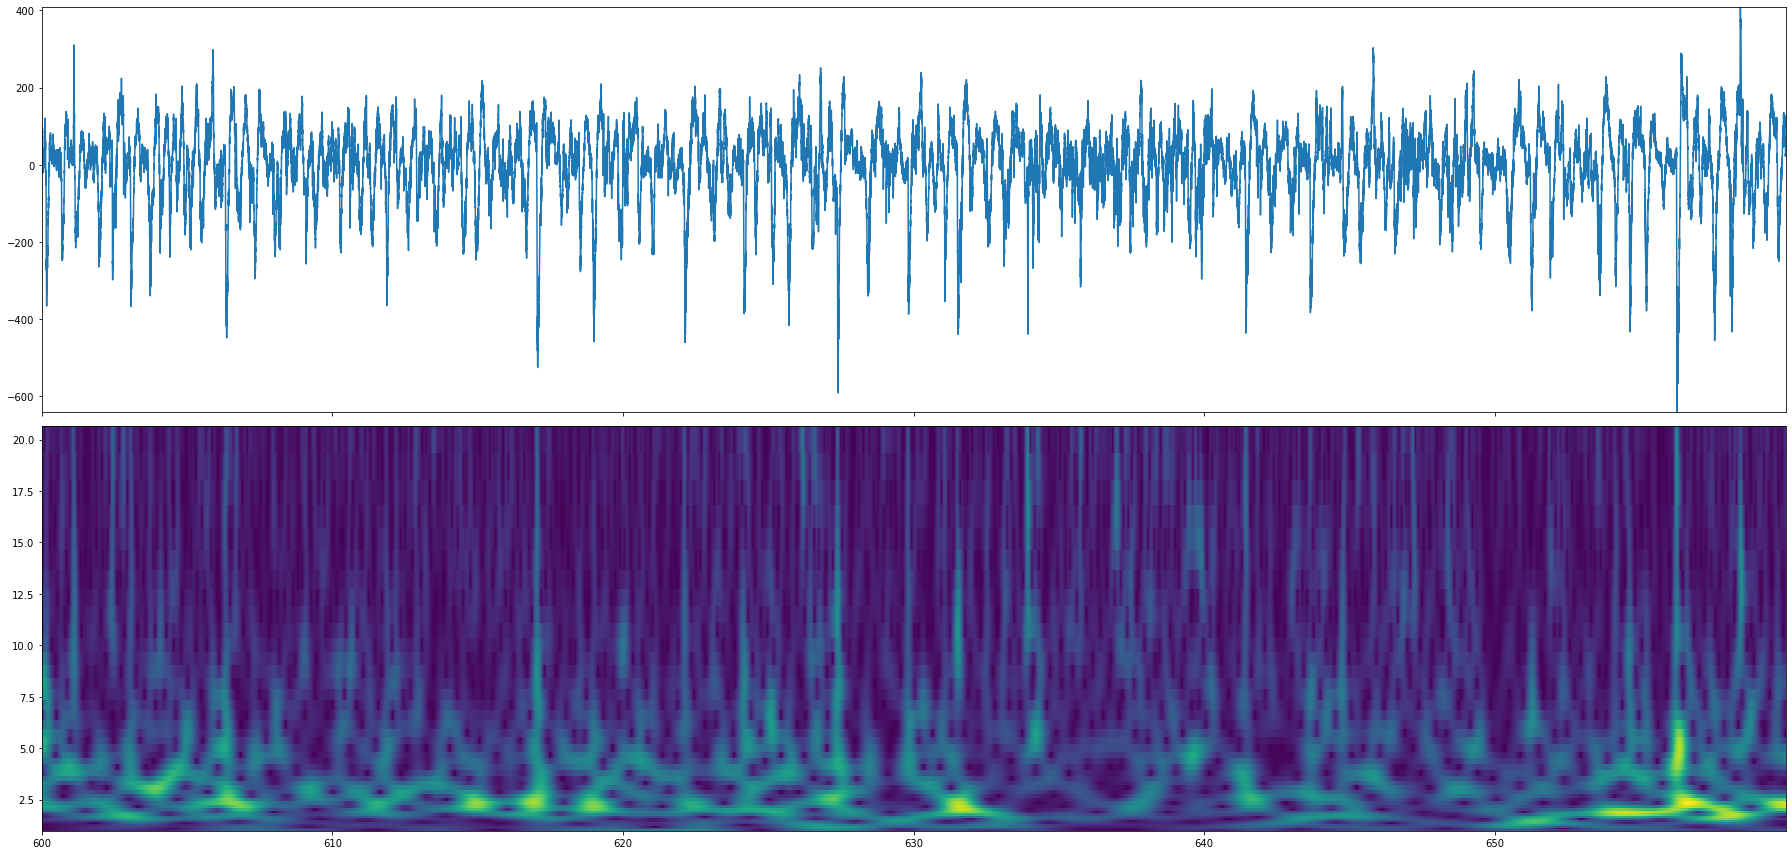

In [71]:
fig, axes = plt.subplots(2,1,figsize=(25, 12), sharex=True)
axes[0].plot(t, v)
axes[0].margins(0, 0)
axes[1].pcolormesh(timestamps, frequencies, np.abs(coefs), shading='auto')
fig.tight_layout()

In [68]:
%%time
psd, freqs = gsp.mtm_spectrum(v, fs=fs, n_fft_threads=8 , bandwidth=20)

CPU times: user 2h 2min 23s, sys: 54.3 s, total: 2h 3min 17s
Wall time: 8min 11s


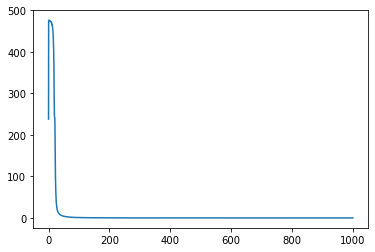

In [69]:
plt.plot(freqs, psd)